In [18]:
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as mp
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as spec
import matplotlib.animation as anim
import scipy.ndimage as img
from jupyterthemes import jtplot

In [19]:
jtplot.reset()
mp.switch_backend("TkAgg")
mpl.interactive(True)
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (5,5)
mp.rcParams["figure.dpi"] = 100

## Lens distortion

In [3]:
def LensDistortion(N, C, L, n):
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X,Y = np.meshgrid(x,y)

    fig = mp.figure(figsize=(5*2, 5))
    ax = fig.add_subplot(121)
    ax.plot(X,Y, "k-")
    ax.plot(Y,X, "k-")
    ax.plot(X,Y, "bo")
    ax.grid()

    cenx, ceny = X[N//2, N//2], Y[N//2, N//2]
    for i in range(N):
        for j in range(N):
            R = np.hypot(X[i,j] - cenx, Y[i,j]-ceny)
            phi = np.arctan2(Y[i,j], X[i,j])
            xp, yp = R*np.cos(phi), R*np.sin(phi)
            dx = C*L/n*(xp**3 + xp*yp**2)
            dy = C*L/n*(xp**2*yp + yp**3)
            X[i,j] += dx
            Y[i,j] += dy

    ax = fig.add_subplot(122)
    mp.plot(X,Y, "k-")
    mp.plot(Y,X, "k-")
    mp.plot(X,Y, "bo")
    mp.show()

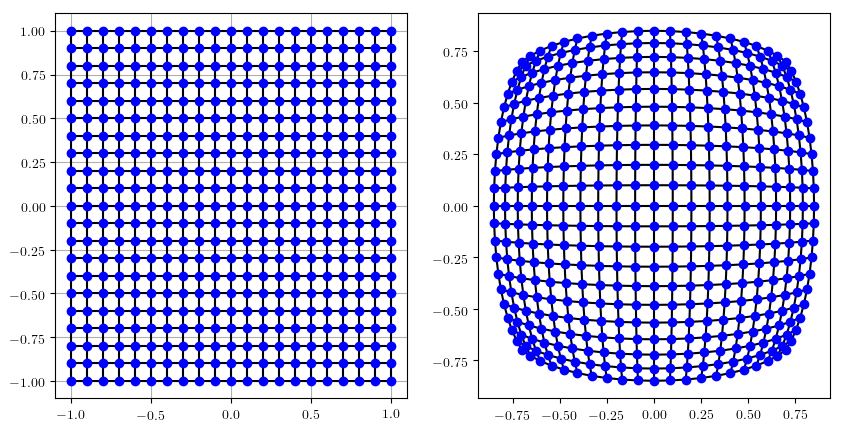

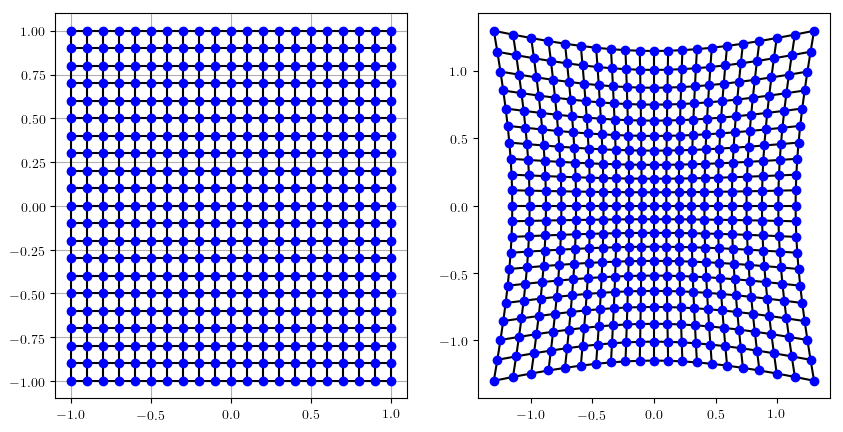

In [5]:
LensDistortion(21, -0.3, 1, 2)
LensDistortion(21, 0.3, 1, 2)

In [53]:
class DistortionAnim:
    
    def __init__(self, N, C, L, n):
        x = np.linspace(-1, 1, N)
        y = np.linspace(-1, 1, N)
        X,Y = np.meshgrid(x,y)
        
        self.N = N
        self.X = X
        self.Y = Y
        self.C = C
        self.L = L
        self.n = n
        self.count = 0
        
    def continue_loop(self):
        while True:
            self.count += 1
            yield self.count
            
    def on_key(self, event):
        key = event.key
        if key == "c":
            self.C += 0.1
        elif key == "x":
            self.C -= 0.1
        elif key =="l":
            self.L += 1
        elif key == "k":
            self.L -= 1
        elif key == "n":
            self.n += 0.05
        elif key == "b":
            if self.n - 0.05 == 0.00:
                pass
            else:
                self.n -= 0.05
        
    def update(self, continue_loop):
        X,Y = self.X, self.Y
        Xp,Yp = np.zeros_like(X), np.zeros_like(Y)
        N = self.N
        C, L, n = self.C, self.L, self.n
        cenx, ceny = X[N//2, N//2], Y[N//2, N//2]
        for i in range(N):
            for j in range(N):
                R = np.hypot(X[i,j] - cenx, Y[i,j]-ceny)
                phi = np.arctan2(Y[i,j], X[i,j])
                xp, yp = R*np.cos(phi), R*np.sin(phi)
                dx = C*L/n*(xp**3 + xp*yp**2)
                dy = C*L/n*(xp**2*yp + yp**3)
                Xp[i,j] = X[i,j] + dx
                Yp[i,j] = Y[i,j] + dy
                
        self.gridpts.set_data(Xp,Yp)
        #self.hor_lines.set_data(Xp,Yp)
        #self.vert_lines.set_data(Yp,Xp)
        self.data_text.set_text(self.data_template %(self.C, self.L, self.n))

        return self.gridpts, self.data_text
        
    def run(self):
        X,Y = self.X, self.Y
        fig, ax = mp.subplots(1, 1, figsize=(5, 5))
        
        self.data_template = r"$C = %.2f$, $L = %.2f$, $n = %.2f$"
        self.data_text = ax.text(0.0, -0.05, "", transform=ax.transAxes, color="k", fontsize=12)
        self.gridpts, = ax.plot([], [], "bo")
        #self.hor_lines, = ax.plot([], [], "k-")
        #self.vert_lines, = ax.plot([], [], "k-")
        ax.grid(True)
        ax.axis("on")
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.axis("off")
        
        self.fig = fig
        self.ax = ax
        
        fig.canvas.mpl_connect("key_press_event", self.on_key)
        ani = anim.FuncAnimation(fig, self.update, self.continue_loop, interval=60, repeat=0)
        mp.tight_layout()
        mp.show(block=1)

In [54]:
sim = DistortionAnim(21, 0.3, 1, 2)
sim.run()

## Astigmatism

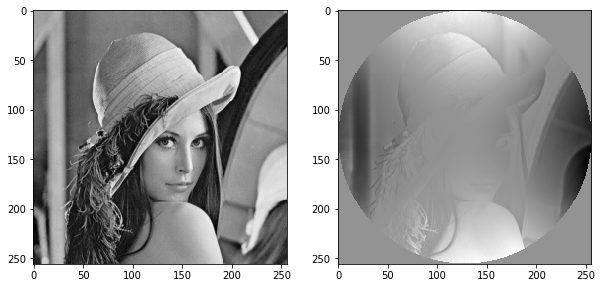

In [11]:
fig = mp.figure(figsize=(5*2,5))
lena = img.imread("lena.png", mode="L")

N = 256
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
X,Y = np.meshgrid(x,y)
Z = np.zeros_like(X)
h,k,rad = 150, 125, 100

for i in range(N):
    for j in range(N):
        if np.hypot(i-N//2,j-N//2) <= rad:
            Z[i,j] = 1

ax = fig.add_subplot(121)
ax.grid(False)
ax.imshow(lena, "gray")

C = 20
L = 1
n = 1.5

R = np.sqrt(X**2 + Y**2)
Phi = np.arctan2(Y,X)
Z1 = np.ones_like(X)
Z1 = C*L/n*(Y**2 - X**2)
Z1 /= np.linalg.norm(Z1, ord=2)
Z1[R>1] = 0

Z2 = lena*Z1

ax = fig.add_subplot(122)
ax.imshow(Z2, "gray")
ax.grid(False)

mp.show()

## Zernike polynomials

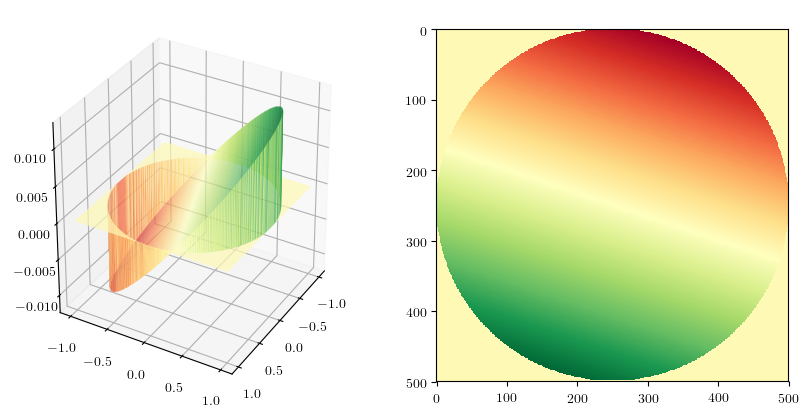

In [11]:
x = np.linspace(-1, 1, 500)
y = x
X,Y = np.meshgrid(x,y)
R = np.sqrt(X**2 + Y**2)
Phi = np.arctan2(Y,X)
Z1 = np.ones_like(R)
Z1[R>1] = 0
Z1 /= la.norm(Z1, ord=2)

Z2 = R*np.sin(Phi)
Z2[R>1] = 0
Z2 /= la.norm(Z2, ord=2)

Z3 = R*np.cos(Phi)
Z3[R>1] = 0
Z3 /= la.norm(Z3, ord=2)

W = 0.2*Z1 + 2.4*Z2 -0.8*Z3

fig = mp.figure(figsize=(5*2,5))
ax = fig.add_subplot(121, projection="3d")
ax.view_init(azim=30, elev=30)
ax.plot_surface(X,Y,W, cmap="RdYlGn", rstride=3, cstride=3, antialiased=True)
ax.grid(True)

ax = fig.add_subplot(122)
ax.imshow(W, "RdYlGn")
ax.grid(False)

mp.show()